In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        x_1 = x_1.reshape(-1,1)
        x_2 = x_1.reshape(-1,1)
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    sc.partial_fit(x_2)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['x_2'][j].append(sc.transform(x_2))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['y'][i] = []
        
    df = trainSet.loc[trainSet['ticker'] == s][['adj_close']]
    mv_rate = 20
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
 
    make_samples(
        data_1,
        data_2,
        s)
    
    if s == 'AEGN':
        break

In [8]:
# Callback functions
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(2,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

# Training model

In [10]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(57760, 2, 60) (57760,)
Fitting prediction interval 1  model
Train on 40432 samples, validate on 17328 samples
Epoch 1/100
40432/40432 [==============================] - 2s 49us/step - loss: 0.3328 - val_loss: 0.0864
Epoch 2/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.1482 - val_loss: 0.0539
Epoch 3/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.1095 - val_loss: 0.0425
Epoch 4/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0852 - val_loss: 0.0359
Epoch 5/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0732 - val_loss: 0.0520
Epoch 6/100
40432/40432 [==============================] - 0s 4us/step - loss: 0.0666 - val_loss: 0.0315
Epoch 7/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0558 - val_loss: 0.0366
Epoch 8/100
40432/40432 [==============================] - 0s 3us/step - loss: 0.0572 - val_loss: 0.0305
Epoch 9/100
40432/40432 [=======================

40157/40157 [==============================] - 0s 3us/step - loss: 0.2175 - val_loss: 0.1175
Epoch 3/100
40157/40157 [==============================] - 0s 4us/step - loss: 0.1625 - val_loss: 0.0899
Epoch 4/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.1340 - val_loss: 0.0765
Epoch 5/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.1158 - val_loss: 0.0684
Epoch 6/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.1019 - val_loss: 0.0775
Epoch 7/100
40157/40157 [==============================] - 0s 4us/step - loss: 0.1004 - val_loss: 0.0625
Epoch 8/100
40157/40157 [==============================] - 0s 4us/step - loss: 0.0881 - val_loss: 0.0716
Epoch 9/100
40157/40157 [==============================] - 0s 3us/step - loss: 0.0861 - val_loss: 0.0596
Epoch 10/100
40157/40157 [==============================] - 0s 4us/step - loss: 0.0804 - val_loss: 0.0633
Epoch 11/100
40157/40157 [==============================] - 0s 3us

## Loss Graph

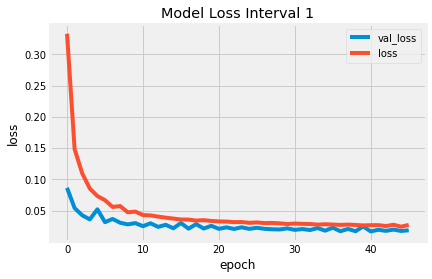

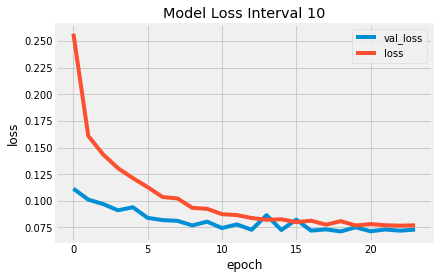

In [11]:
for i in [1,10]:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

In [12]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [13]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

# Predicting with Test Set

In [14]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    df = testSet.loc[testSet['ticker'] == s][['adj_close']]
    mv_rate = 20
    data_1 = df.values
    data_1 = data_1[mv_rate -1:]
    
    data_2 = df.rolling(mv_rate).mean().values
    data_2 = data_2[mv_rate-1:]
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)

                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(x_2)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['x_2'][j].append(sc.transform(x_2))
                    test_set[s]['y'][j].append(y)
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [15]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predict test sample

In [16]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 23.630826363491114
Test Set -> MSE of AAPL inveral 3: 35.94253688581143
Test Set -> MSE of AAPL inveral 5: 53.45236283996965
Test Set -> MSE of AAPL inveral 10: 79.9388496005381


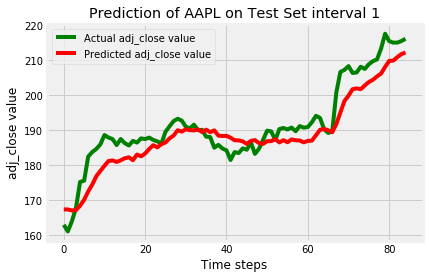

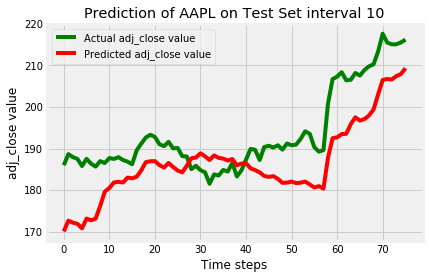

In [17]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 10 symbols

In [18]:
test_symbols = ['A', 'ACER', 'ABC', 'AAPL', 'BABA']

In [19]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [20]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [21]:
all_mse_1

[2.24, 3.03, 8.28, 23.63, 53.41]

In [22]:
all_mse_10

[3.52, 6.62, 20.97, 79.94, 142.98]

In [23]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 2)))

MSE of Interval 10 = 1.57 Interval 1
MSE of Interval 10 = 2.18 Interval 1
MSE of Interval 10 = 2.53 Interval 1
MSE of Interval 10 = 3.38 Interval 1
MSE of Interval 10 = 2.68 Interval 1
